<a href="https://colab.research.google.com/github/igornunespatricio/spark-project-customer-churn/blob/main/machine_learning_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting Up environment


1.   Install Java
2.   Install and unpack Spark and Hadoop Distributed File System (HDFS)
3.   Define environment variables for Java and Spark
4.   Install and initialize findspark
5.   Check Spark installation



In [1]:
# Java installation
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [2]:
# Downloading Spark and Hadoop Distributed File System (HDFS) files
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz

# Unpacking files
!tar xf spark-3.1.2-bin-hadoop2.7.tgz

In [3]:
# Importing os library
import os

# Defining Java's system variable
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

# Defining Spark's system variable
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop2.7"

In [4]:
# Necessary to run PySpark
!pip install -q findspark

In [5]:
# Importing installed finspark library
import findspark

# Initialize findspark
findspark.init()

In [6]:
# # Importing package to initialize Spark session
from pyspark.sql import SparkSession

# # Imprting package to get number of cpu workers
# import multiprocessing

# cores = multiprocessing.cpu_count() # Count the number of cores in the computer
# print(f"Computer has {cores} cores")

# # Initialize spark session
# sc = SparkSession.builder.master('local[*]').getOrCreate()

# # Check if session was created
# sc

If everything is right, the output of the last cell should per below:

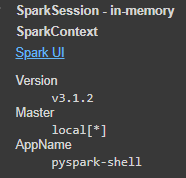

# Downloading Kaggle Dataset

In this case, a customer-churn dataset found [here](https://www.kaggle.com/datasets/muhammadshahidazeem/customer-churn-dataset) will be used. More info on the dataset in this link.

1. Install Kaggle package
2. Upload kaggle.json file with credentials (follow instructions [here](https://www.kaggle.com/discussions/general/74235))
3. Create kaggle directory
4. Upload kaggle.json file
5. Change permition of kaggle json file
6. Copy API command from the Kaggle dataset you want to use by clicking in $\ \vdots$  
 and then "Copy API Command". In this case, [this](https://www.kaggle.com/datasets/muhammadshahidazeem/customer-churn-dataset) dataset is being used
7. Paste the copied command above in a new code cell and run
8. After waiting the download to finish, under the /content diretory you should have the zipped file with the dataset in the /content directory
9. Unzip the data into a directory of choice. In this case, "customer-churn"

In [7]:
# Importing Kaggle package
!pip install -q kaggle

In [8]:
# Upload your Kaggles API secret KEY in file kaggle.json (link: https://www.kaggle.com/discussions/general/74235)
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"igornunespatricio","key":"7f5d35c1c5bd7334abed0a8e12172c4c"}'}

In [9]:
# Create kaggle directory
!mkdir ~/.kaggle

In [10]:
# Copy kaggle json file to the created directory
! cp kaggle.json ~/.kaggle/

In [11]:
# Change permission of the file
!chmod 600 ~/.kaggle/kaggle.json

In [12]:
# Check if everything is correct
!kaggle datasets list

ref                                                         title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
nelgiriyewithana/countries-of-the-world-2023                Global Country Information Dataset 2023           23KB  2023-07-08 20:37:33          10309        398  1.0              
juhibhojani/house-price                                     House Price                                        7MB  2023-08-02 16:51:21           1416         51  0.9411765        
arnavsmayan/netflix-userbase-dataset                        Netflix Userbase Dataset                          25KB  2023-07-04 07:38:41          11858        206  1.0              
alphiree/cardiovascular-diseases-risk-prediction-dataset    Cardiovascular Diseases Risk Predic

In [13]:
# Downloading the Dataset from Kaggle
!kaggle datasets download -d muhammadshahidazeem/customer-churn-dataset

 75% 5.00M/6.66M [00:00<00:00, 35.5MB/s]
100% 6.66M/6.66M [00:00<00:00, 45.5MB/s]


In [14]:
# Unzipping content to another folder
!unzip /content/customer-churn-dataset.zip -d customer-churn

Archive:  /content/customer-churn-dataset.zip
  inflating: customer-churn/customer_churn_dataset-testing-master.csv  
  inflating: customer-churn/customer_churn_dataset-training-master.csv  


# Machine Learning

In [15]:
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf

pyspark_config = [
    ('spark.app.name','Customer-Churn'),
    ('spark.executor.memory','4g'),
    ('spark.master','local[*]'),
    ('spark.driver.memory','4g'),
    ('spark.driver.cores','2')
]

conf = SparkConf().setAll(pyspark_config)

sp = SparkSession.builder.config(conf=conf).getOrCreate()

# print(sp.sparkContext.getConf().get("spark.master"))
# print(sp.sparkContext.getConf().get("spark.executor.memory"))

for configuration in pyspark_config:
    config_value = sp.sparkContext.getConf().get(configuration[0])
    print(f"{configuration[0]}: {config_value}")

spark.app.name: Customer-Churn
spark.executor.memory: 4g
spark.master: local[*]
spark.driver.memory: 4g
spark.driver.cores: 2


In [16]:
FILEPATH = "/content/customer-churn/customer_churn_dataset-training-master.csv"
# Read csv file (if another file  type, search PySpark documentation)
df = sp.read.options(header=True, inferSchema=True).csv(FILEPATH)
df.printSchema()

root
 |-- CustomerID: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- Usage Frequency: integer (nullable = true)
 |-- Support Calls: integer (nullable = true)
 |-- Payment Delay: integer (nullable = true)
 |-- Subscription Type: string (nullable = true)
 |-- Contract Length: string (nullable = true)
 |-- Total Spend: double (nullable = true)
 |-- Last Interaction: integer (nullable = true)
 |-- Churn: integer (nullable = true)



In [17]:
# train and test split
seed = 42
df_train, df_test = df.randomSplit(weights=[0.7, 0.3], seed=seed)

In [18]:
num_churns = df_test.rdd.map(lambda x: x["Churn"]==1).sum()
total = df_test.count()
print(f'Churns: {num_churns}\nTotal observations: {total}\nProportion of Churns: {num_churns/total:.4%}')

Churns: 75143
Total observations: 132195
Proportion of Churns: 56.8425%


In [19]:
from pyspark.sql.functions import count, when, isnull
# Checking Null values
df.agg(*[count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

+----------+---+------+------+---------------+-------------+-------------+-----------------+---------------+-----------+----------------+-----+
|CustomerID|Age|Gender|Tenure|Usage Frequency|Support Calls|Payment Delay|Subscription Type|Contract Length|Total Spend|Last Interaction|Churn|
+----------+---+------+------+---------------+-------------+-------------+-----------------+---------------+-----------+----------------+-----+
|         1|  1|     1|     1|              1|            1|            1|                1|              1|          1|               1|    1|
+----------+---+------+------+---------------+-------------+-------------+-----------------+---------------+-----------+----------------+-----+



In [30]:
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from xgboost.spark import SparkXGBClassifier

# Use int and double types columns as features for random forest model
feature_col = [col_name for col_name, col_type in df.dtypes if (col_type in ('int', 'double') and (col_name not in ('Churn', 'CustomerID')))]
assembler = VectorAssembler(inputCols=feature_col, outputCol='features', handleInvalid='skip')

# Models to use
models = {
    "logisticRegression": LogisticRegression(featuresCol="features", labelCol="Churn"),
    'randomForest': RandomForestClassifier(numTrees=2, maxDepth=2, featuresCol='features', labelCol="Churn", seed=42),
    'xgboost': SparkXGBClassifier(features_col="features", label_col="Churn", num_workers=2)
}

# Pipelines to train
pipelines = {key: Pipeline(stages= [assembler, classifier]) for key, classifier in models.items()}

# Checking pipelines
[print(f'{key}: {pipeline.getStages()}') for key, pipeline in pipelines.items()]

# Training pipelines
trained_models = {
    key: pipeline.fit(df_train) for key, pipeline in pipelines.items()
    }

# Checking trained models
[print(f'{key}: {trained_model.stages}') for key, trained_model in trained_models.items()]

# Predicting models
predictions = {
    key: trained_model.transform(df_test).select("Churn", "prediction", "probability") for key, trained_model in trained_models.items()
}

In [36]:
# Checking confusion matrix of models
[print(f'{key}', {prediction.groupby("Churn", "prediction").count().show()}) for key, prediction in predictions.items()]

+-----+----------+-----+
|Churn|prediction|count|
+-----+----------+-----+
|    1|       0.0|11573|
|    0|       0.0|47942|
|    1|       1.0|63570|
|    0|       1.0| 9110|
+-----+----------+-----+

logisticRegression {None}
+-----+----------+-----+
|Churn|prediction|count|
+-----+----------+-----+
|    1|       0.0|17421|
|    0|       0.0|56661|
|    1|       1.0|57722|
|    0|       1.0|  391|
+-----+----------+-----+

randomForest {None}
+-----+----------+-----+
|Churn|prediction|count|
+-----+----------+-----+
|    1|       0.0| 3491|
|    0|       0.0|57042|
|    1|       1.0|71652|
|    0|       1.0|   10|
+-----+----------+-----+

xgboost {None}


[None, None, None]

In [61]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.sql.dataframe import DataFrame

binary_evaluator = BinaryClassificationEvaluator(labelCol="Churn", rawPredictionCol="prediction")
multi_evaluator = MulticlassClassificationEvaluator(labelCol="Churn", predictionCol="prediction", probabilityCol='probability')
binary_metric_names = ['areaUnderROC', 'areaUnderPR']
multiclass_metric_names = "f1|accuracy|weightedPrecision|weightedRecall|weightedTruePositiveRate| weightedFalsePositiveRate|weightedFMeasure|truePositiveRateByLabel| falsePositiveRateByLabel|precisionByLabel|recallByLabel|fMeasureByLabel| logLoss|hammingLoss"
multiclass_metric_names = [item.strip() for item in multiclass_metric_names.split('|')]

def Metrics(
    pred: DataFrame = None,
    binaryEvaluator: BinaryClassificationEvaluator = None,
    binaryMetrics: list[str] = None,
    multiclassEvaluator: MulticlassClassificationEvaluator = None,
    multiclassMetrics: list[str] = None,
    verbose=None
    ) -> dict:
    """
    Calculate Binary and Multiclass metrics.
    """
    metrics = dict()
    multiclass_metrics = dict()
    if pred and binaryEvaluator and binaryMetrics:
        binary_metrics = dict()
        print("Binary Metrics") if verbose else ""
        for item in binaryMetrics:
            binary_metric = binaryEvaluator.evaluate(
                dataset=pred,
                params={
                    binaryEvaluator.metricName: item
                    }
            )
            binary_metrics[item] = binary_metric
            print(f'{item}: {binary_metric:.2%}') if verbose else ""
        print('\n')
    if pred and multiclassEvaluator and multiclassMetrics:
        print("\nMulticlass Metrics") if verbose else ""
        for item in multiclass_metric_names:
            multi_metric = multi_evaluator.evaluate(
                dataset=pred,
                params={
                    multi_evaluator.metricName: item
                }
            )
            multiclass_metrics[item] = multi_metric
            print(f'{item}: {multi_metric:.2%}') if verbose else ""
    metrics["Binary"] = binary_metrics
    metrics["Multiclass"] = multiclass_metrics
    return metrics

# Creates a pandas dataframe with metric values with metric names in rows and model names in columns
import pandas as pd
comparision_dataframe = pd.DataFrame(
    columns=list(predictions.keys()),
    index=binary_metric_names+multiclass_metric_names
    )
for model_name, prediction in predictions.items():
    metrics = Metrics(
        pred=prediction,
        binaryEvaluator = binary_evaluator,
        binaryMetrics=binary_metric_names,
        multiclassEvaluator=multi_evaluator,
        multiclassMetrics=multiclass_metric_names
    )
    metrics_dict = {
        metric_name: value for task_metric, dict_metrics in metrics.items() for metric_name, value in dict_metrics.items()
    }
    for metric_name, value in metrics_dict.items():
        comparision_dataframe.loc[metric_name, model_name] = value

In [71]:
from google.colab import files

# Saves the dataframe as excel file
comparision_dataframe.to_excel('model_comparision.xlsx', index=True)
files.download('model_comparision.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [64]:
# Saving models
[trained_model.write().overwrite().save(model_name) for model_name, trained_model in trained_models.items()]

[None, None, None]

In [67]:
# Downloading models
import subprocess
from google.colab import files

for model_name in trained_models.keys():
    subprocess.call(f"zip -r {model_name}.zip {model_name}/", shell=True)

In [70]:
# Downloading trained models
for model_name in trained_models.keys():
    files.download(f'{model_name}.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# TODO

1. Need to check how to save and load transformers with parameters passed by user in pyspark

2. apply categorical features also from the link on step 2 above